___
## Ciência dos Dados - PROJETO 3 - INSPER

___
#### Arthur Alegro de Oliveira

#### Rafael dos Santos

#### José Antônio Bechara

___

# Classificação de Apps

___

## A. INTRODUÇÃO

Objetivo: Prever a nota de um app da PlayStore ou da AppStore

___
## B. MINERANDO DADOS e CARACTERÍSTICAS DO DATASET

[Detalhe aqui as características da base de dados além da análise descritiva.]

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os

### BASE DE DADOS

Carregando *database*:

In [2]:
# Reading Google Play Store data:
Google_data = pd.read_csv('googleplaystore.csv')

In [3]:
Google_data.head(1)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up


Ao analisar o *database* notamos que algumas colunas possuem dados numéricos em sua essência, mas por possuir outros caracteres são interpretados como texto. A seguir, serão destrinchados os problemas em cada umas dessas colunas. As funções que serão usadas já estão definidas abaixo:

In [4]:
def remove_last_char(word):
    new_word = word[:-1]
    return new_word

def remove_comma(word):
    new_word = "".join(word.split(','))
    return new_word

def remove_first_char(word):
    if '$' in word:
        new_word = word[1:]
        return new_word
    else:
        return word

Coluna `Size`:  
* possui o último caractere não numérico

In [5]:
Google_data['Size'] = Google_data['Size'].apply(remove_last_char)

 Coluna `Installs`:  
 * possui o último caractere não numérico
 * possui vírgulas como separador a cada $10^3$
 * possui dois tipos valores não itendificados (`Fre` e ` ` ) que serão descartados

In [6]:
Google_data['Installs'] = Google_data['Installs'].apply(remove_last_char)
Google_data['Installs'] = Google_data['Installs'].apply(remove_comma)
Google_data['Installs'] = Google_data['Installs'][Google_data['Installs'] != 'Fre']
Google_data['Installs'] = Google_data['Installs'][Google_data['Installs'] != '']

 Coluna `Price`: 
* possui o primeiro caractere $\$$ quando não é valor nulo (ou seja, quando o aplicativo é gratuito)
* possui um tipo de valor não identificado (`Everyone`) que será descartado

In [7]:
Google_data['Price'] = Google_data['Price'].apply(remove_first_char)
Google_data['Price'] = Google_data['Price'][Google_data['Price'] != 'Everyone']

Coluna `Reviews`:
* Possui um valor $3.0M$ (equivalente a $3000000$)

In [8]:
Google_data['Reviews'] = Google_data['Reviews'].mask(Google_data['Reviews'] == '3.0M', 3000000)

Com todas as filtragens e correções feitas, é possível modificar o tipo de dado para cada coluna de acordo com a necessidade. Logo, as colunas com valores qualitativos serão interpretadas como `category`, enquanto as colunas com valores quantitativos serão interpretadas como `float` ou `int`(dependendo se os valores originais possuem ou não casas decimais).

In [9]:
Google_data['Category'] = Google_data['Category'].astype('category')
Google_data['Rating'] = Google_data['Rating'].astype('float64')
Google_data['Reviews'] = Google_data['Reviews'].astype('float64')
Google_data['Installs'] = Google_data['Installs'].astype('float64')
Google_data['Price'] = Google_data['Price'].astype('float64')
Google_data['Content Rating'] = Google_data['Content Rating'].astype('category')
Google_data['Genres'] = Google_data['Genres'].astype('category')

Ainda que os dados sejam categóricos, alguns classificadores somente funcionam se todos os dados forem numéricos. O código abaixo resolve esse código, selecionando todos os possíveis valores dos dados categóricos e substituindo-os por valores numéricos. 

In [10]:
for column in ['Category', 'Content Rating', 'Genres']:
    
    values = list(Google_data[column].value_counts().keys())

    for value, number in zip(values, range(len(values))):
        Google_data[column] = Google_data[column].mask(Google_data[column] == value, number)

In [11]:
usefull_columns = ["App", "Category", "Rating", "Reviews", "Installs", "Price", "Content Rating", "Genres"]
Google_data = Google_data[usefull_columns]

App --> str, ex:'Photo Editor & Candy Camera & Grid & ScrapBook' <br>
Category --> str, ex: 'ART_AND_DESIGN' <br>
Rating --> float, ex: 4.0999999 <br>
Reviews --> str, ex: 159 <br>
Installs --> str, ex: 10,000+ <br>
Price --> str, ex: '0' <br>
Content Rating --> str, ex: Everyone <br>
Genres --> str, ex: 'Art & Design' <br>

### ANÁLISE DESCRITIVA

Para melhor compreensão dos dados que serão utilizados, uma análise mais detalhada de cada uma das variáveis se faz necessária.

Inicialmente os dados serão abordados da seguinte forma:
* Dados quantitativos serão exibidos em forma de histogramas
* Dados qualitativos serão exibidor em forma de gráfico de barras

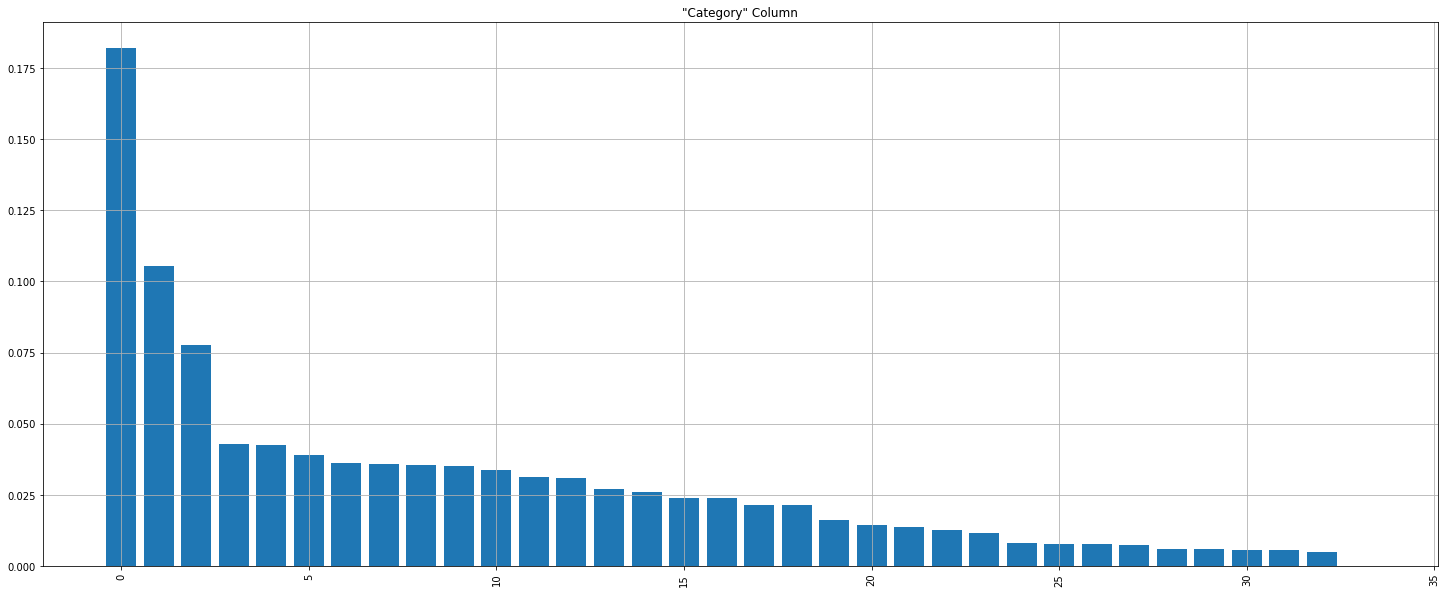

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


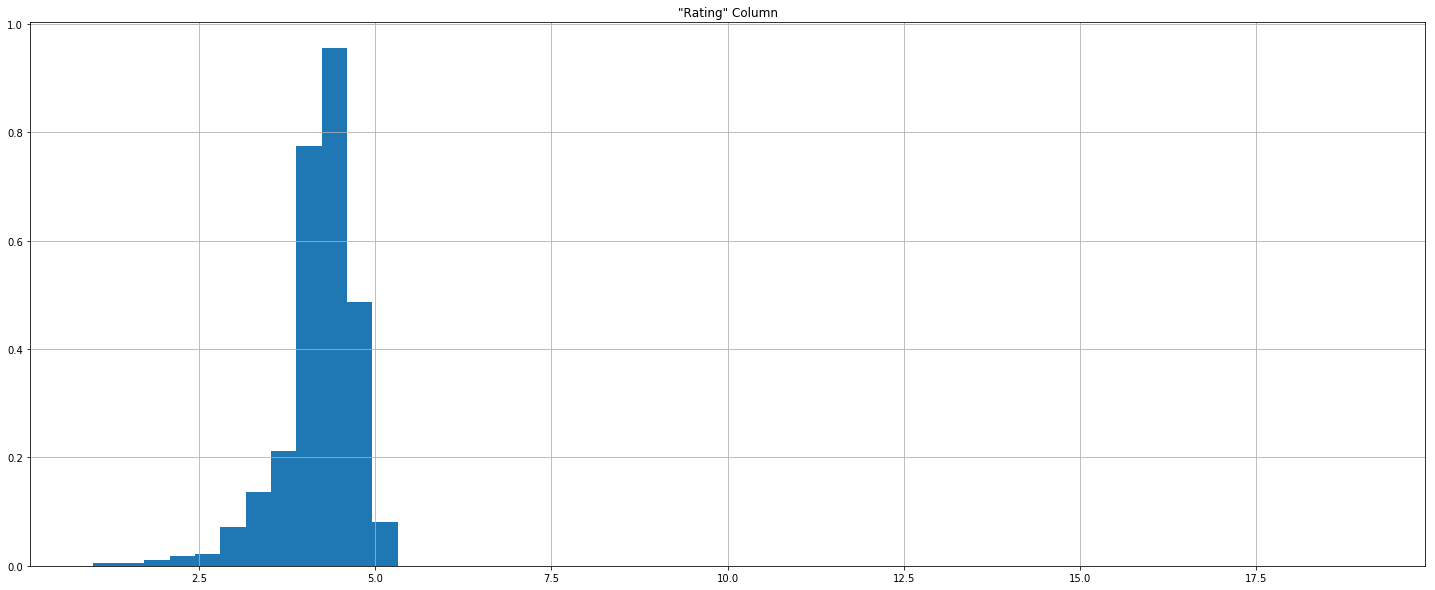

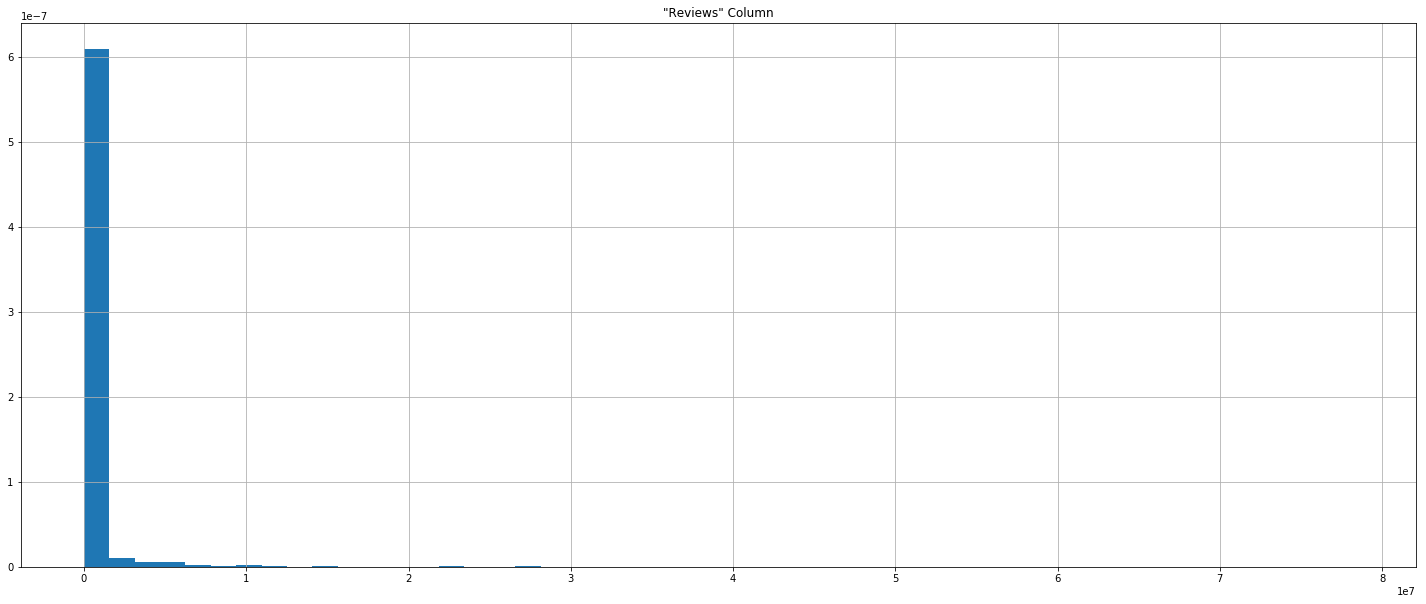

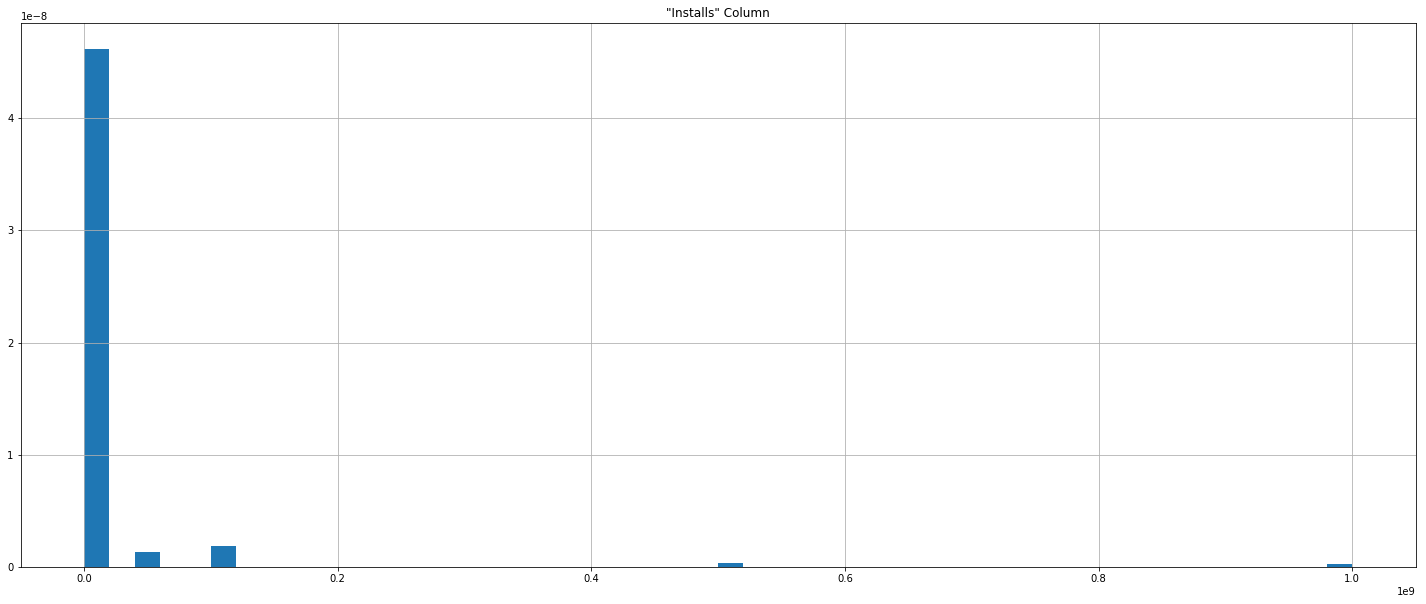

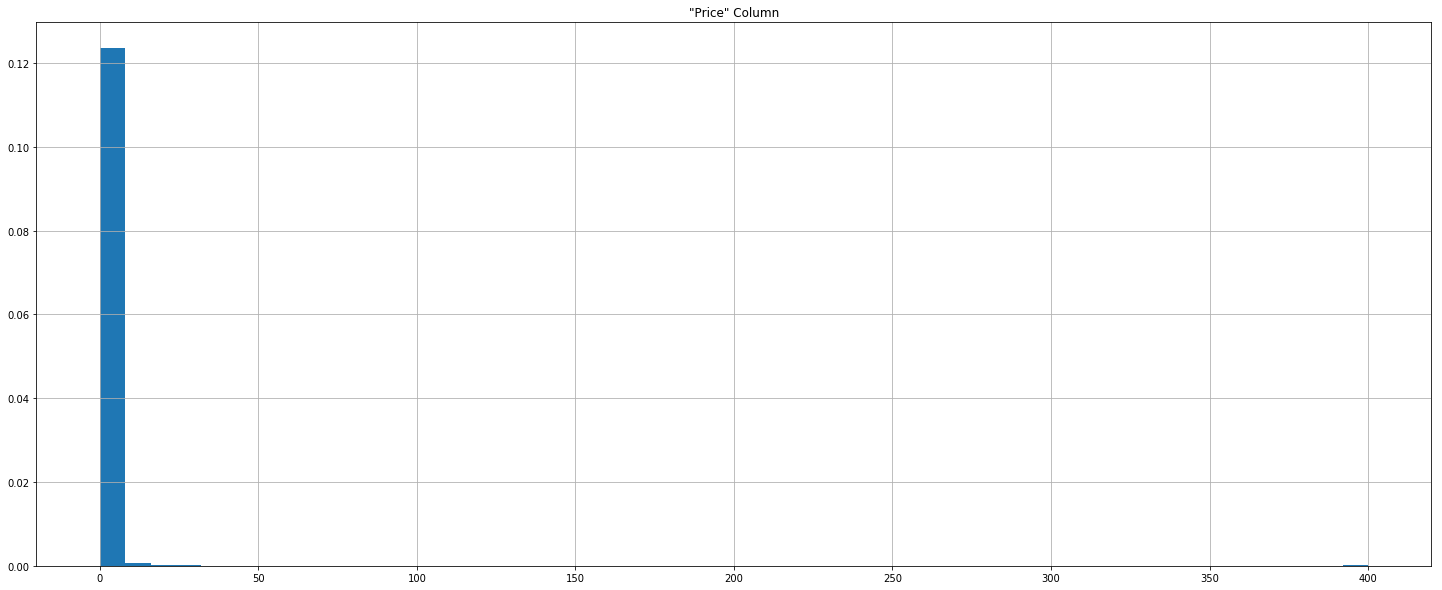

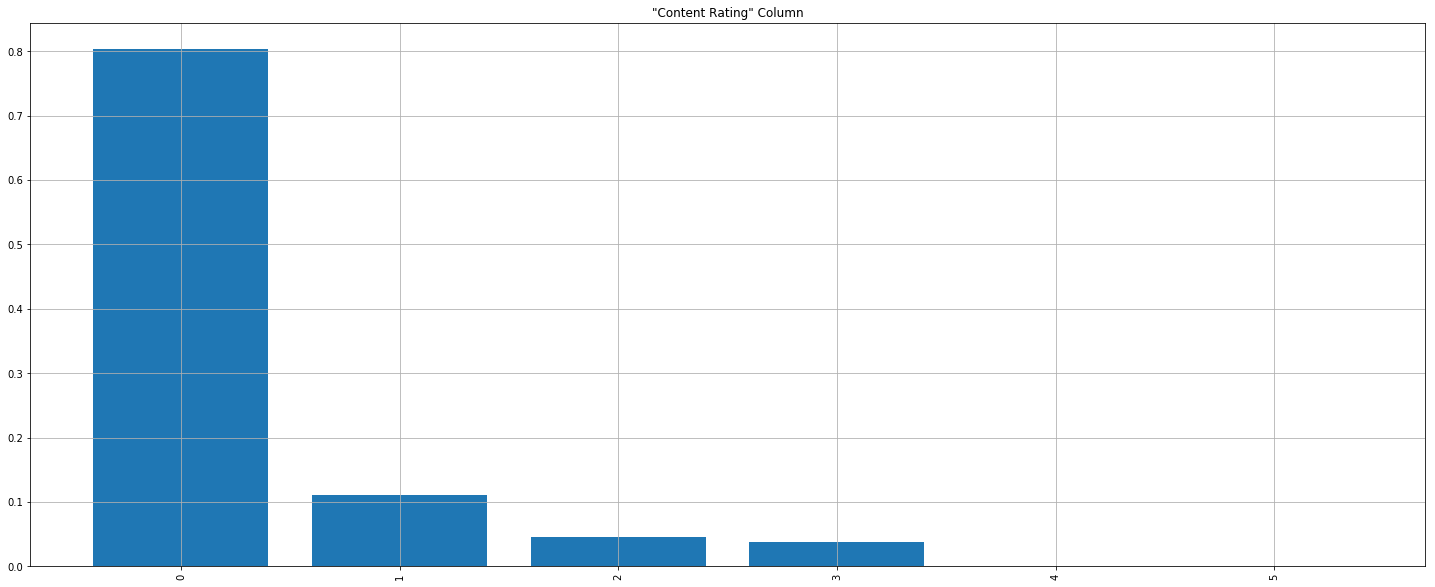

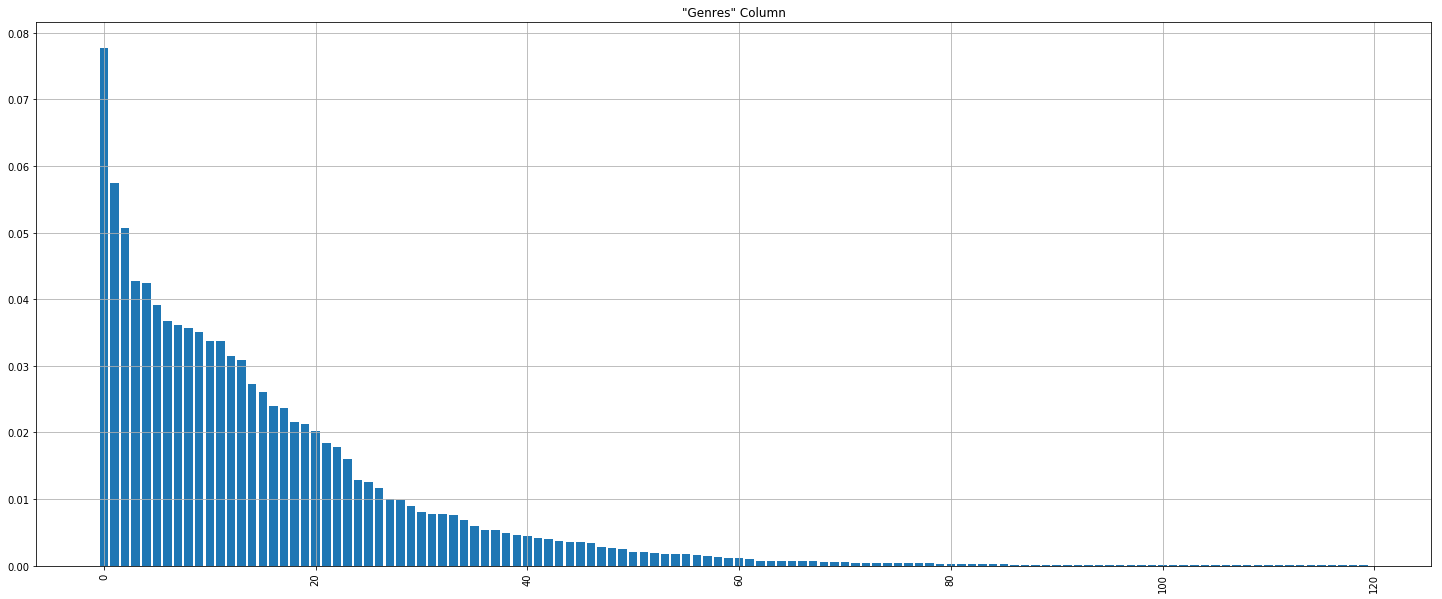

In [12]:
plt.figure(figsize=(25,10))
plt.bar(Google_data['Category'].value_counts(normalize=True).keys(), Google_data['Category'].value_counts(normalize=True).values)
plt.xticks(rotation='vertical')
plt.title('"Category" Column')
plt.grid()
plt.show()

plt.figure(figsize=(25,10))
plt.hist(Google_data['Rating'], bins=50, density='normed')
plt.title('"Rating" Column')
plt.grid()
plt.show()

plt.figure(figsize=(25,10))
plt.hist(Google_data['Reviews'], bins=50, density='normed')
plt.title('"Reviews" Column')
plt.grid()
plt.show()

plt.figure(figsize=(25,10))
plt.hist(Google_data['Installs'], bins=50, density='normed')
plt.title('"Installs" Column')
plt.grid()
plt.show()

plt.figure(figsize=(25,10))
plt.hist(Google_data['Price'], bins=50, density='normed')
plt.title('"Price" Column')
plt.grid()
plt.show()

plt.figure(figsize=(25,10))
plt.bar(Google_data['Content Rating'].value_counts(normalize=True).keys(), Google_data['Content Rating'].value_counts(normalize=True).values)
plt.xticks(rotation='vertical')
plt.title('"Content Rating" Column')
plt.grid()
plt.show()

plt.figure(figsize=(25,10))
plt.bar(Google_data['Genres'].value_counts(normalize=True).keys(), Google_data['Genres'].value_counts(normalize=True).values)
plt.xticks(rotation='vertical')
plt.title('"Genres" Column')
plt.grid()
plt.show()

Também plotamos um "gráfico de temperatura" (*heatmap*) mostrando correlação entre as variáveis. A legenda do lado direito mostra que quando maior a correlação entre as variáveis mais claro a intersecção entre as duas variáveis de referência.

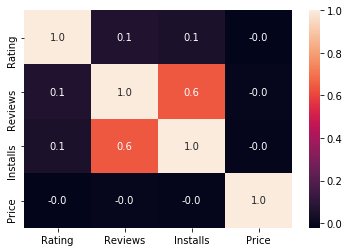

In [13]:
sns.heatmap(Google_data.corr(), annot = True, fmt='.1f')

Abaixo há um gráfico de correlação, cruzando cada uma das variáveis de interesse. Nas diagonais são mostrados histogramas de densidade de variáveis, uma vez que a correlação entre a variável com ela mesma sempre retornará 100%.

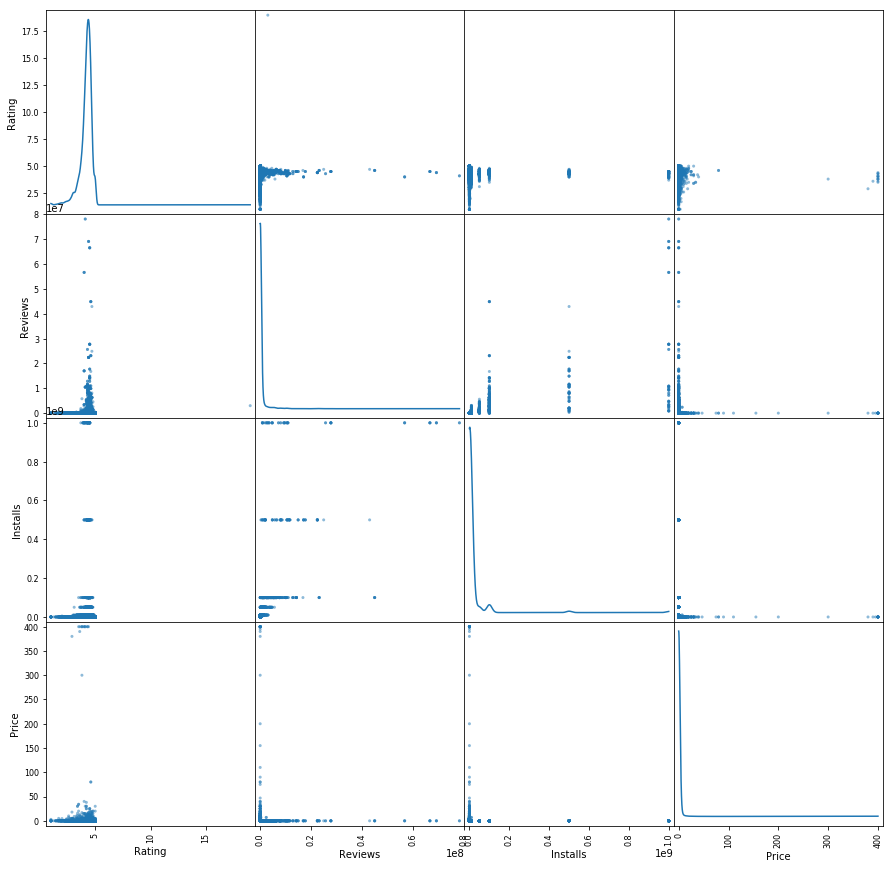

In [14]:
pd.plotting.scatter_matrix(Google_data, figsize=(15,15), diagonal='kde');
plt.show()

___
## C. MODELOS DE PREDIÇÃO

A função `dummify` serve para separar colunas de variáveis qualitativas em múltiplas colunas.

Exemplo, separar a coluna "sexo" em 2 colunas: "sexo_masculino" e "sexo_feminino", sendo que cada linha fica com um `1` quando ela era verdade e um `0` quando não.

In [15]:
def dummify(data, column_name):
    df = data.copy()
    df2 = pd.concat([df.drop(column_name, axis=1), pd.get_dummies(data[column_name], prefix=column_name)], axis=1)
    return df2

In [16]:
Google_data = dummify(Google_data, "Category")
Google_data = dummify(Google_data, "Content Rating")
Google_data = dummify(Google_data, "Genres")

As funções abaixo serão utilizadas para calcular erros dos diferentes modelos e posteriormente compor a tabela no item **D (Processo e Estatísticas de Validação)**. A relação das funções é a seguinte:

* A função `R2` calcula o erro $R^2$ (r squared error)
* A função `RMS` calcula o erro $RMS$ (mean squared error)

In [17]:
def R2(test, pred):
    R2 = mean_squared_error(y_test, y_pred)
    return R2

def RMS(test, pred):
    RMS = mean_squared_error(test, pred)
    return RMS

Para utilizar os diferentes modelos de predição, primeiro é necessário separar o *database* em base de testes e base de treinamento.

A base de treinamento será 70% do *database* e a base de testes os 30% restantes (aproximadamente).

Para evitar alguns conflitos gerados durante o desenvolvimento do projeto, a base de dados será dividida separadamente para cada um dos modelos. Portanto as células estão organizadas da seguinte forma:
* A primeira célula é a divisão do *database*
* A segunda célula é a implementação do modelo em si que consiste em:
    * Função que implementa o modelo
    * Predição considerando TREINAMENTO e TESTE
    * Calculo dos erros $R^2$ e $RMS$ para cada uma das considerações anteriores

### MODELO DE PREDIÇÃO PELA MÉDIA (Sem uso de variável explicativa):

In [18]:
PlayStore_X = list(Google_data.columns)
Google_data = Google_data.dropna()
PlayStore_X.remove("App")
PlayStore_Y = 'Rating'

Google_data_X = Google_data[PlayStore_X]
Google_data_Y = Google_data[PlayStore_Y]

X_train, X_test, y_train, y_test = train_test_split(Google_data_X, Google_data_Y, test_size=.3)

In [19]:
def mean_predict(df):
    mean = np.mean(df)
    y_pred = []
    for val in df:
        y_pred.append(mean)
    return y_pred

mean_pred_train = mean_predict(y_train)
mean_pred_test = mean_predict(y_test)

mean_train_R2 = r2_score(y_train, mean_pred_train)
mean_train_RMS = mean_squared_error(y_train, mean_pred_train)
mean_test_R2 = r2_score(y_test, mean_pred_test)
mean_test_RMS = mean_squared_error(y_test, mean_pred_test)

### MODELO DOS K VIZINHOS MAIS PRÓXIMOS (K-Nearest Neighbors Regression):

In [20]:
PlayStore_X = list(Google_data.columns)
Google_data = Google_data.dropna()
PlayStore_X.remove("App")
PlayStore_X.remove("Rating")
PlayStore_Y = 'Rating'

Google_data_X = Google_data[PlayStore_X]
Google_data_Y = Google_data[PlayStore_Y]

X_train, X_test, y_train, y_test = train_test_split(Google_data_X,Google_data_Y,test_size=.3)

In [21]:
def knn_model(X_fit, y_fit, X_pred):
    knn_model = KNeighborsRegressor(11)
    knn_model.fit(X_fit, y_fit)
    y_pred = knn_model.predict(X_pred)
    return y_pred

KNN_pred_train = knn_model(X_train, y_train, X_train)
KNN_pred_test = knn_model(X_test, y_test, X_test)

KNN_train_R2 = r2_score(y_train, KNN_pred_train)
KNN_train_RMS = mean_squared_error(y_train, KNN_pred_train)
KNN_test_R2 = r2_score(y_test, KNN_pred_test)
KNN_test_RMS = mean_squared_error(y_test, KNN_pred_test)

### MODELO DE REGRESSÃO LINEAR (Multiple Linear Regression):

In [22]:
PlayStore_X = list(Google_data.columns)
Google_data = Google_data.dropna()
PlayStore_X.remove("App")
PlayStore_X.remove("Rating")
PlayStore_Y = 'Rating'

Google_data_X = Google_data[PlayStore_X]
Google_data_Y = Google_data[PlayStore_Y]

X_train, X_test, y_train, y_test = train_test_split(Google_data_X,Google_data_Y,test_size=.3)

In [23]:
def LR_model(X_fit, y_fit, X_pred):
    lr_model = LinearRegression()
    lr_model.fit(X_fit, y_fit)
    y_pred = lr_model.predict(X_pred)
    return y_pred

LR_pred_train = LR_model(X_train, y_train, X_train)
LR_pred_test = LR_model(X_test, y_test, X_test)

LR_train_R2 = r2_score(y_train, LR_pred_train)
LR_train_RMS = mean_squared_error(y_train, LR_pred_train)
LR_test_R2 = r2_score(y_test, LR_pred_test)
LR_test_RMS = mean_squared_error(y_test, LR_pred_test)

### MODELO DE ÁRVORES DE REGRESSÃO (Decision Tree Regression):

In [24]:
PlayStore_X = list(Google_data.columns)
Google_data = Google_data.dropna()
PlayStore_X.remove("App")
PlayStore_X.remove("Rating")
PlayStore_Y = 'Rating'

Google_data_X = Google_data[PlayStore_X]
Google_data_Y = Google_data[PlayStore_Y]

X_train, X_test, y_train, y_test = train_test_split(Google_data_X,Google_data_Y,test_size=.3)

In [25]:
def tree_reg_model(X_fit, y_fit, X_pred):
    tree = DecisionTreeRegressor()
    tree.fit(X_fit, y_fit)
    y_pred = tree.predict(X_pred)
    return y_pred

tree_pred_train = knn_model(X_train, y_train, X_train)
tree_pred_test = knn_model(X_test, y_test, X_test)

tree_train_R2 = r2_score(y_train, tree_pred_train)
tree_train_RMS = mean_squared_error(y_train, tree_pred_train)
tree_test_R2 = r2_score(y_test, tree_pred_test)
tree_test_RMS = mean_squared_error(y_test, tree_pred_test)

___
## D. PROCESSO E ESTATÍSTICAS DE VALIDAÇÃO

Após as diferentes modelagens e o cálculo dos erros $R^2$ e $RMS$ será criado duas tabelas comparando os erros obtidos em cada um dos modelos usando dados diferentes (TESTE e TREINAMENTO).

In [26]:
index = ['Mean', 'K-NN', 'Linear Regression', 'Tree Regresion']
columns_R2 = ['$R^2$ considerando dados TREINAMENTO', '$R^2$ considerando dados TESTE']
columns_RMS = ['$RMS$ considerando dados TREINAMENTO', '$RMS$ considerando dados TESTE']

data_R2 = [[mean_train_R2, mean_test_R2],
           [KNN_train_R2, KNN_test_R2],
           [LR_train_R2, LR_test_R2],
           [tree_train_R2, tree_train_R2]]

data_RMS = [[mean_train_RMS, mean_test_RMS],
           [KNN_train_RMS, KNN_test_RMS],
           [LR_train_RMS, LR_train_RMS],
           [tree_train_RMS, tree_train_RMS]]

R2_table = pd.DataFrame(data_R2, index=index, columns=columns_R2)
RMS_table = pd.DataFrame(data_RMS, index=index, columns=columns_RMS)

A tabela abaixo relaciona o erro $R^2$ considerando dados TREINAMENTO e TESTE com os diferentes modelos estatísticos implementados.

In [30]:
RMS_table

,$RMS$ considerando dados TREINAMENTO,$RMS$ considerando dados TESTE
Mean,0.277442,0.237355
K-NN,0.198899,0.204205
Linear Regression,0.246119,0.246119
Tree Regresion,0.198741,0.198741


A tabela abaixo relaciona o erro $RMS$ considerando dados TREINAMENTO e TESTE com os diferentes modelos estatísticos implementados.

In [29]:
R2_table

,$R^2$ considerando dados TREINAMENTO,$R^2$ considerando dados TESTE
Mean,0.000000,0.000000
K-NN,0.244169,0.245536
Linear Regression,0.052185,0.060947
Tree Regresion,0.239057,0.239057


___
## E. CONCLUSÃO

As duas tabelas acima nos mostram a medida de erro ($RMS$) e a medida de qualidade ($R^2$) com relação aos diversos modelos implementados. Assim sendo, temos que:

* Se tratando de $R^2$, quanto maior o valor, melhor
* Se tratando de $RMS$, quanto menor o valor, melhor

Portanto, o melhor modelo é aquele com o maior valor de $R^2$ e com o menor valor de $RMS$.

___
## F. REFERÊNCIAS BIBLIOGRÁFICAS

Os seguintes links foram usados para a elaboração deste projeto:

> https://scikit-learn.org/
>
> https://medium.com/data-py-blog/decision-tree-regression-in-python-b185a3c63f2b
>
> https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
>
> https://educationalresearchtechniques.com/2018/11/02/k-nearest-neighbor-regression-with-python/
>
> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
>
> https://seaborn.pydata.org/generated/seaborn.set_style.html?highlight=set_style#seaborn.set_style
>
> https://seaborn.pydata.org/search.html?q=set_style&check_keywords=yes&area=default